# Kryptographie: Hashing und Symmetrische Verschlüsselung

In diesem Notebook werden **zwei Hashverfahren** (SHA-2, SHA-3) und **zwei symmetrische Verschlüsselungsverfahren** (AES, Blowfish) auf einen Datensatz angewendet.


## Begründung der Auswahl der Verfahren

**Hashverfahren:**
- Der Hauptunterschied zwischen SHA2 und SHA3 ist das interne Algorithmusdesign, wenig Gemeinsamkeiten (außer den Namen). Daher deckt dieses Notebook beide Verfahren ab. Beide Verfahren gelten als sicher.
- **SHA-2 (SHA-256)**
  Der Hauptunterschied zwischen SHA2 und SHA3 ist das interne Algorithmusdesign, sie haben wenig bzw. keine Gemeinsamkeiten (außer den Namen). Daher deckt dieses Notebook beide Verfahren ab. Beide Verfahren gelten als sicher. SHA-2 ist in vielen sicherheitsrelevanten Anwendungen im Einsatz. SHA-2 ist im Vergleich zu SHA3 in vielen Implementierungen schneller, besonders auf älterer Hardware (https://piproductora.com/de/was-ist-der-unterschied-zwischen-sha-3-und-sha-256/)

- **SHA-3 (z. B. SHA3-256)** – neuer NIST-Standard, basiert auf einer anderen Konstruktion (wie Keccak). SHA-3 ist resistent gegen Längenerweiterungsangriffe
  SHA-3 wurde 2015 standardisiert und unterscheidet sich strukturell komplett von SHA-2. Laut NIST ist es nicht als Ersatz, sondern als zusätzliche Absicherung gedacht (https://stackoverflow.com/questions/14356526/whats-the-difference-between-the-hash-algorithms-sha-2-and-sha-3) Es ist resistent gegen Angriffstechniken, die theoretisch bei SHA-2 wirken könnten, und bietet mit SHAKE flexible Ausgabelängen (https://piproductora.com/de/was-ist-der-unterschied-zwischen-sha-3-und-sha-256/)

**Symmetrische Verschlüsselung:**
- **Blowfish** – schneller Algorithmus mit variabler Schlüssellänge, bei open source Verschlüsselungssoftware sehr beliebt. Allein für Implementierungen bei denen häufig neue Schlüssel erzeugt werden müssen, beispielsweise VPN, eignet sich Blowfish weniger. (https://www.infopoint-security.de/des-aes-blowfish-was-sind-die-sichersten-algorithmen-fuer-verschluesselungssoftware/a8366/)

- **AES (z. B. AES-256 im CBC-Modus)** – Industriestandard, sehr sicher, effizient und für große Datenmengen geeignet.  
  AES ist seit 2000 der offizielle Nachfolger von DES, weltweit der Standard in sicherheitskritischen Anwendungen (z. B. VPNs). Es arbeitet mit 128-Bit-Blöcken und 128/192/256-Bit Schlüsseln. AES ist sowohl sicher als auch performant und wird kontinuierlich geprüft (https://www.infopoint-security.de/des-aes-blowfish-was-sind-die-sichersten-algorithmen-fuer-verschluesselungssoftware/a8366/)

## Vorbereitung

### Link zum Datensatz
https://www.kaggle.com/datasets/nadeemajeedch/employee-performance-and-salary-dataset/

Der Employee Performance and Salary Dataset enthält Informationen zu Mitarbeitenden wie Alter, Geschlecht, Abteilung, Gehalt, Eintrittsdatum, Leistung, Erfahrung, Status und Arbeitszeit.
Er umfasst sowohl numerische als auch kategoriale Daten und weist teilweise fehlende Werte bei der Leistungsbewertung auf.
Die Daten ermöglichen Analysen zu Trends in Gehalt, Leistung und Beschäftigungsstatus über verschiedene Zeiträume und Standorte hinweg.
Mit insgesamt 12 Spalten und zahlreichen Einträgen eignet sich der Datensatz gut für Aufgaben in den Bereichen Datenanalyse, Visualisierung und maschinelles Lernen.

In [45]:
! pip install -q kaggle

In [46]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Übergabe von Kaggle Benutzer Daten:
{"username":"....","key":"...."}

In [47]:
# ... Hier ihre JSON Cred als dictionary eingeben
d_json_cred ={"username":"lizzldizzl","key":"7126d6d48a18986c8a8704fbb94e4a44"}

Kaggle Zugangsdaten speichern



In [48]:
import pandas as pd
kaggle_cred = pd.DataFrame(d_json_cred, index=[0]).to_json("~/.kaggle/kaggle.json")

Authorisierung geben dass Kaggle Daten heruntergeladen werden dürfen

In [49]:
! chmod 600 ~/.kaggle/kaggle.json

In [50]:
!kaggle datasets download -d nadeemajeedch/employee-performance-and-salary-dataset

Dataset URL: https://www.kaggle.com/datasets/nadeemajeedch/employee-performance-and-salary-dataset
License(s): Community Data License Agreement - Sharing - Version 1.0
employee-performance-and-salary-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


Unzip der Daten

In [51]:
!unzip employee-performance-and-salary-dataset.zip -d ./data

Archive:  employee-performance-and-salary-dataset.zip
replace ./data/50_Tasks_to_perform_on_dataset.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace ./data/Employe_Performance_dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no


### Pakete installieren

In [52]:
!pip install pandas
!pip install cryptography
!pip install pycryptodome
!pip install matplotlib numpy



## Datensatz


In [53]:
import pandas as pd

# Pfad zur entpackten CSV-Datei
file_path = "./data/Employe_Performance_dataset.csv"

# CSV in DataFrame laden
df = pd.read_csv(file_path)

# Erste Zeilen ausgeben
print(df.head())


   ID                Name  Age  Gender Department  Salary Joining Date  \
0   1        Cory Escobar   48  Female         HR    5641   2015-05-03   
1   2     Timothy Sanchez   25   Other      Sales    4249   2020-11-09   
2   3        Chad Nichols   57   Other      Sales    3058   2019-02-12   
3   4  Christine Williams   58  Female         IT    5895   2017-09-08   
4   5        Amber Harris   35   Other         IT    4317   2020-02-15   

   Performance Score  Experience    Status     Location  Session  
0                2.0          16    Active     New York    Night  
1                2.0          11  Inactive  Los Angeles  Evening  
2                NaN           1  Inactive     New York  Morning  
3                2.0          13  Inactive  Los Angeles  Evening  
4                5.0          16  Inactive     New York  Evening  



## Hashing – Integritätsprüfung mit SHA2

1. Datensatz mit SHA-256 verschlüsseln.


In [54]:
import hashlib
import time

# DataFrame als CSV-String umwandeln
# Annahme: 'df' ist Ihr Pandas DataFrame
csv_string = df.to_csv(index=False)
data_to_hash = csv_string.encode()

# --- Zeitmessung starten ---
start_time = time.time()

# SHA-256 (SHA-2 Familie)
sha256_full = hashlib.sha256(data_to_hash).hexdigest()

# --- Zeitmessung stoppen ---
end_time = time.time()

# Zeitdifferenz berechnen
first_execution_time = end_time - start_time

print("SHA-256-Hash des gesamten Dokuments:", sha256_full)
print(f"Dauer der Hashing-Berechnung: {first_execution_time:.6f} Sekunden")

SHA-256-Hash des gesamten Dokuments: 6d0e81ad3755d4ede9af1bfa28df9f4114e69f6b98995e19b888afbb70ed54b7
Dauer der Hashing-Berechnung: 0.000414 Sekunden


2. Eine Änderung im Datensatz simulieren.

In [55]:
df_mod1 = df.copy()

# Salary in der ersten Zeile leicht ändern
df_mod1.loc[0, "Salary"] = 5642

# Ausgabe
df_mod1.head()

,ID,Name,Age,Gender,Department,Salary,Joining Date,Performance Score,Experience,Status,Location,Session
0,1,Cory Escobar,48,Female,HR,5642,2015-05-03,2.0,16,Active,New York,Night
1,2,Timothy Sanchez,25,Other,Sales,4249,2020-11-09,2.0,11,Inactive,Los Angeles,Evening
2,3,Chad Nichols,57,Other,Sales,3058,2019-02-12,NaN,1,Inactive,New York,Morning
3,4,Christine Williams,58,Female,IT,5895,2017-09-08,2.0,13,Inactive,Los Angeles,Evening
4,5,Amber Harris,35,Other,IT,4317,2020-02-15,5.0,16,Inactive,New York,Evening


3. Hash des (unwissentlich) veränderten Datensatzes berechnen (z. B. als Empfänger)

In [56]:
import hashlib
import time

# Annahme: 'df_mod1' ist Ihr geänderter Pandas DataFrame
data_to_hash_modified = df_mod1.to_csv(index=False).encode()

# --- Zeitmessung starten ---
start_time_mod = time.time()

# SHA-256-Hash des geänderten DataFrames berechnen
sha256_full_modified = hashlib.sha256(data_to_hash_modified).hexdigest()

# --- Zeitmessung stoppen ---
end_time_mod = time.time()

# Zeitdifferenz berechnen
second_execution_time_mod = end_time_mod - start_time_mod

print("SHA-256-Hash des geänderten Dokuments:", sha256_full_modified)
print(f"Dauer der Hash-Berechnung (geändert): {second_execution_time_mod:.6f} Sekunden")

SHA-256-Hash des geänderten Dokuments: 13e645f0a622c58a97aa97d8620c262a2081aca0d5a4597f2aec91ef198dc0fa
Dauer der Hash-Berechnung (geändert): 0.000279 Sekunden


4. Hash-Werte vergleichen

In [57]:
# Direkter Vergleich der Hash-Werte
print("### Integritätsprüfung der DataFrames (SHA-256) ###")
print(f"Original-Hash: {sha256_full}")
print(f"Geänderter Hash: {sha256_full_modified}")
print("-" * 50)


if sha256_full == sha256_full_modified:
    print("✅ Integrität intakt! Die Hash-Werte stimmen überein.")
else:
    print("❌ Integrität verletzt! Die Hash-Werte sind NICHT gleich.")
    print("Die Daten (DataFrames) wurden zwischen den Messungen verändert.")

### Integritätsprüfung der DataFrames (SHA-256) ###
Original-Hash: 6d0e81ad3755d4ede9af1bfa28df9f4114e69f6b98995e19b888afbb70ed54b7
Geänderter Hash: 13e645f0a622c58a97aa97d8620c262a2081aca0d5a4597f2aec91ef198dc0fa
--------------------------------------------------
❌ Integrität verletzt! Die Hash-Werte sind NICHT gleich.
Die Daten (DataFrames) wurden zwischen den Messungen verändert.


Die Veränderung wird beim Vergleich der beiden Hashwerte sofort sichtbar. Ein Manipulations- oder Fälschungsversuch würde dadurch auffallen – etwa, wenn innerhalb eines Unternehmens eine Datei dupliziert und verändert weitergeleitet wird oder wenn man eine Datei aus dem Internet herunterlädt und den bekannten Original-Hashwert zum Abgleich heranzieht.


## Hashing – Integritätsprüfung mit SHA3

1. Datensatz mit SHA3-256 verschlüsseln.


In [58]:
import hashlib
import time

# DataFrame als CSV-String umwandeln
# Annahme: 'df' ist Ihr Pandas DataFrame
csv_string = df.to_csv(index=False)
data_to_hash = csv_string.encode()

# --- Zeitmessung starten ---
start_time = time.time()

# SHA3-256 (SHA-3 Familie, Keccak)
sha3_256_full = hashlib.sha3_256(data_to_hash).hexdigest()

# --- Zeitmessung stoppen ---
end_time = time.time()

# Zeitdifferenz berechnen
third_execution_time = end_time - start_time

print("SHA3-256-Hash des gesamten Dokuments:", sha3_256_full)
print(f"Dauer der Hashing-Berechnung (SHA3-256): {third_execution_time:.6f} Sekunden")

SHA3-256-Hash des gesamten Dokuments: 76e6e26835985a7b8b67357581e661baca2cbc010b9792062087c50e0f643497
Dauer der Hashing-Berechnung (SHA3-256): 0.000381 Sekunden


2. Eine Änderung am Datensatz simulieren

In [59]:
df_mod2 = df.copy()

# Salary in der ersten Zeile leicht ändern
df_mod2.loc[0, "Salary"] = 5646

# Ausgabe
df_mod2.head()

,ID,Name,Age,Gender,Department,Salary,Joining Date,Performance Score,Experience,Status,Location,Session
0,1,Cory Escobar,48,Female,HR,5646,2015-05-03,2.0,16,Active,New York,Night
1,2,Timothy Sanchez,25,Other,Sales,4249,2020-11-09,2.0,11,Inactive,Los Angeles,Evening
2,3,Chad Nichols,57,Other,Sales,3058,2019-02-12,NaN,1,Inactive,New York,Morning
3,4,Christine Williams,58,Female,IT,5895,2017-09-08,2.0,13,Inactive,Los Angeles,Evening
4,5,Amber Harris,35,Other,IT,4317,2020-02-15,5.0,16,Inactive,New York,Evening


3. Hash des (unwissentlich) veränderten Datensatzes berechnen (z. B. als Empfänger)

In [60]:
import hashlib
import time

# Annahme: 'df_mod2' ist Ihr geänderter Pandas DataFrame
data_to_hash_modified = df_mod2.to_csv(index=False).encode()

# --- Zeitmessung starten ---
start_time_mod = time.time()

# SHA3-256-Hash des geänderten DataFrames berechnen
sha3_256_full_modified = hashlib.sha3_256(data_to_hash_modified).hexdigest()

# --- Zeitmessung stoppen ---
end_time_mod = time.time()

# Zeitdifferenz berechnen
fourth_execution_time_mod = end_time_mod - start_time_mod

print("SHA3-256-Hash des geänderten Dokuments:", sha3_256_full_modified)
print(f"Dauer der Hash-Berechnung (SHA3-256, geändert): {fourth_execution_time_mod:.6f} Sekunden")

SHA3-256-Hash des geänderten Dokuments: 0c6eba2716f8723f2137e550ed2818a6e745ebe057d33f4bb0539757a43447a9
Dauer der Hash-Berechnung (SHA3-256, geändert): 0.000396 Sekunden


4. Hash-Werte vergleichen

In [61]:
# Direkter Vergleich der Hash-Werte
print("### Integritätsprüfung der DataFrames (SHA-256) ###")
print(f"Original-Hash: {sha3_256_full}")
print(f"Geänderter Hash: {sha3_256_full_modified}")
print("-" * 50)


if sha3_256_full == sha3_256_full_modified:
    print("✅ Integrität intakt! Die Hash-Werte stimmen überein.")
else:
    print("❌ Integrität verletzt! Die Hash-Werte sind NICHT gleich.")
    print("Die Daten (DataFrames) wurden zwischen den Messungen verändert.")

### Integritätsprüfung der DataFrames (SHA-256) ###
Original-Hash: 76e6e26835985a7b8b67357581e661baca2cbc010b9792062087c50e0f643497
Geänderter Hash: 0c6eba2716f8723f2137e550ed2818a6e745ebe057d33f4bb0539757a43447a9
--------------------------------------------------
❌ Integrität verletzt! Die Hash-Werte sind NICHT gleich.
Die Daten (DataFrames) wurden zwischen den Messungen verändert.


Die Veränderung wird erneut beim Vergleich der beiden Hashwerte sofort sichtbar. Auch hier würde Ein Manipulations- oder Fälschungsversuch auffallen.


## Symmetrische Verschlüsselung – AES

1. Es wird simuliert, wie ein Mitarbeiter eine Datei verschlüsselt und anschließend die verschlüsselte Version abspeichert.

In [62]:
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from cryptography.hazmat.primitives import hashes
import os
import time  # <--- Import für die Zeitmessung

# --- Setup und Schlüsselableitung (Unverändert) ---

# Passwort (bekannt bei Absender und Empfänger)
password = b"MeinGeheimesPasswort"

# Salt und IV erzeugen
salt = os.urandom(16)
iv = os.urandom(16)

# Schlüssel aus Passwort ableiten
kdf = PBKDF2HMAC(
    algorithm=hashes.SHA256(),
    length=32,
    salt=salt,
    iterations=100000,
    backend=default_backend()
)
key = kdf.derive(password)

# Datei laden (Annahme: file_path ist definiert und zeigt auf die Originaldatei)
# ACHTUNG: Stellen Sie sicher, dass 'file_path' in Ihrem Notebook definiert ist.
try:
    with open(file_path, "rb") as f:
        plaintext = f.read()
except NameError:
    # FÜR TESTZWECKE: Erstellen von 5 MB Dummy-Daten, falls file_path nicht definiert ist.
    print("WARNUNG: 'file_path' nicht gefunden. Verwende Dummy-Daten (5 MB).")
    plaintext = b"A" * 1024 * 1024 * 5

# Padding (PKCS#7-ähnliches Padding für CBC)
BS = 16 # AES Blockgröße
padding_length = BS - (len(plaintext) % BS)
padded = plaintext + bytes([padding_length]) * padding_length


# --- Zeitmessung starten ---
start_time = time.time()

# Verschlüsseln
cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
encryptor = cipher.encryptor()
ciphertext = encryptor.update(padded) + encryptor.finalize()

# --- Zeitmessung stoppen ---
end_time = time.time()

# Zeitdifferenz berechnen
aesencryption_time = (end_time - start_time) * 1000 # Zeit in Millisekunden

# --- Speichern (Unverändert) ---

# Speicherpfad festlegen
save_dir = os.path.expanduser("~/Documents/Krypto")
os.makedirs(save_dir, exist_ok=True)

enc_file_path = os.path.join(save_dir, "employee_data.enc")

# Salt + IV + Ciphertext zusammen speichern
with open(enc_file_path, "wb") as f:
    f.write(salt + iv + ciphertext)

print("-" * 50)
print("Datei erfolgreich mit AES verschlüsselt!")
print(f"Datenmenge: {len(plaintext)/1024/1024:.2f} MB")
print(f"Dauer der Verschlüsselung: {aesencryption_time:.4f} ms")
print("Gespeichert unter:", enc_file_path)
print("-" * 50)

--------------------------------------------------
Datei erfolgreich mit AES verschlüsselt!
Datenmenge: 0.07 MB
Dauer der Verschlüsselung: 0.5901 ms
Gespeichert unter: /root/Documents/Krypto/employee_data.enc
--------------------------------------------------


2. Der empfangende Mitarbeiter kann die Datei mit dem gemeinsam bekannten Passwort wieder entschlüsseln, sodass ausschließlich er Zugriff auf die Inhalte hat und die Daten sicher übertragen wurden.

In [63]:
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from cryptography.hazmat.primitives import hashes
import os
import time # <--- Import für die Zeitmessung

# --- Setup und Datenextraktion (Unverändert) ---

# Passwort (muss dasselbe sein wie beim Verschlüsseln!)
password = b"MeinGeheimesPasswort"

# Speicherpfad für verschlüsselte Datei (muss existieren)
# Hier muss der Pfad zur verschlüsselten Datei verwendet werden
save_dir = os.path.expanduser("~/Documents/Krypto")
enc_file_path = os.path.join(save_dir, "employee_data.enc")

# Datei laden
try:
    with open(enc_file_path, "rb") as f:
        file_data = f.read()
except FileNotFoundError:
    print(f"Fehler: Verschlüsselte Datei nicht gefunden unter {enc_file_path}. Bitte zuerst verschlüsseln!")
    # Beenden oder Dummy-Daten verwenden, falls Datei fehlt.
    # Hier wird abgebrochen, um Fehler zu vermeiden.
    exit()

# Salt, IV und Ciphertext extrahieren
salt = file_data[:16]
iv = file_data[16:32]
ciphertext = file_data[32:]

# Schlüssel aus Passwort und Salt ableiten
kdf = PBKDF2HMAC(
    algorithm=hashes.SHA256(),
    length=32,
    salt=salt,
    iterations=100000,
    backend=default_backend()
)
# Die Zeitmessung startet hier NACH der langsamen Schlüsselableitung
key = kdf.derive(password)

# --- Zeitmessung starten ---
start_time = time.time()

# Entschlüsseln
cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
decryptor = cipher.decryptor()
decrypted_padded = decryptor.update(ciphertext) + decryptor.finalize()

# Padding-Länge ermitteln und entfernen (Wird oft als Teil des Entschlüsselungsprozesses betrachtet)
padding_length = decrypted_padded[-1]
decrypted = decrypted_padded[:-padding_length]

# --- Zeitmessung stoppen ---
end_time = time.time()

# Zeitdifferenz berechnen
aesdecryption_time = (end_time - start_time) * 1000 # Zeit in Millisekunden

# --- Speichern (Unverändert) ---

# Entschlüsselte Datei speichern
dec_file_path = os.path.join(save_dir, "employee_data_decrypted.csv")
with open(dec_file_path, "wb") as f:
    f.write(decrypted)

print("-" * 50)
print("Datei erfolgreich entschlüsselt!")
print(f"Dauer der Entschlüsselung: {aesdecryption_time:.4f} ms")
print("Gespeichert unter:", dec_file_path)
print("-" * 50)

--------------------------------------------------
Datei erfolgreich entschlüsselt!
Dauer der Entschlüsselung: 0.3707 ms
Gespeichert unter: /root/Documents/Krypto/employee_data_decrypted.csv
--------------------------------------------------


Ergebnis: Auf diese Weise können Mitarbeiter Dokumente verschlüsselt austauschen, die nur von Personen mit dem richtigen Passwort geöffnet werden können.

## Symmetrische Verschlüsselung – Blowfish

1. Es wird simuliert, wie ein Mitarbeiter eine Datei verschlüsselt und anschließend die verschlüsselte Version abspeichert.

In [64]:
from Crypto.Cipher import Blowfish
from Crypto.Protocol.KDF import PBKDF2
import os
import time # <--- Import für die Zeitmessung

# --- Setup und Schlüsselableitung ---

# Passwort (bekannt bei Absender und Empfänger)
password = b"MeinGeheimesPasswort"

# Salt erzeugen
salt = os.urandom(16)

# Schlüssel aus Passwort ableiten (max. 56 Byte für Blowfish)
# Die KDF ist absichtlich langsam, um Brute-Force-Angriffe zu erschweren
key = PBKDF2(password, salt, dkLen=32, count=100000)

# IV erzeugen (8 Byte, weil Blowfish Blockgröße = 64 Bit)
iv = os.urandom(8)

# Datei laden (Annahme: file_path ist definiert)
# ACHTUNG: Stellen Sie sicher, dass 'file_path' in Ihrem Notebook definiert ist.
try:
    with open(file_path, "rb") as f:
        plaintext = f.read()
except NameError:
    print("WARNUNG: 'file_path' nicht gefunden. Verwende Dummy-Daten (5 MB).")
    plaintext = b"A" * 1024 * 1024 * 5

# Padding (auf 8 Byte auffüllen)
BS_BF = 8 # Blowfish Blockgröße
padding_length_bf = BS_BF - (len(plaintext) % BS_BF)
padded = plaintext + bytes([padding_length_bf]) * padding_length_bf

# --- Zeitmessung starten ---
start_time = time.time()

# Verschlüsseln
cipher = Blowfish.new(key, Blowfish.MODE_CBC, iv=iv)
ciphertext = cipher.encrypt(padded)

# --- Zeitmessung stoppen ---
end_time = time.time()

# Zeitdifferenz berechnen
encryption_time = (end_time - start_time) * 1000 # Zeit in Millisekunden

# --- Speichern ---

# Speicherpfad festlegen
save_dir = os.path.expanduser("~/Documents/Krypto")
os.makedirs(save_dir, exist_ok=True)

enc_file_path = os.path.join(save_dir, "employee_data_blowfish.enc")

# Salt + IV + Ciphertext zusammen speichern
with open(enc_file_path, "wb") as f:
    f.write(salt + iv + ciphertext)

print("-" * 50)
print("Datei erfolgreich mit Blowfish verschlüsselt!")
print(f"Dauer der Verschlüsselung: {encryption_time:.4f} ms")
print("Gespeichert unter:", enc_file_path)
print("-" * 50)

--------------------------------------------------
Datei erfolgreich mit Blowfish verschlüsselt!
Dauer der Verschlüsselung: 0.8976 ms
Gespeichert unter: /root/Documents/Krypto/employee_data_blowfish.enc
--------------------------------------------------


2. Der empfangende Mitarbeiter kann die Datei mit dem gemeinsam bekannten Passwort wieder entschlüsseln, sodass ausschließlich er Zugriff auf die Inhalte hat und die Daten sicher übertragen wurden.

In [65]:
from Crypto.Cipher import Blowfish
from Crypto.Protocol.KDF import PBKDF2
import os
import time # <--- Import für die Zeitmessung

# --- Setup und Datenextraktion ---

# Passwort (muss dasselbe sein wie beim Verschlüsseln!)
password = b"MeinGeheimesPasswort"

# Speicherpfad für verschlüsselte Datei (muss existieren)
save_dir = os.path.expanduser("~/Documents/Krypto")
enc_file_path = os.path.join(save_dir, "employee_data_blowfish.enc")

# Datei laden
try:
    with open(enc_file_path, "rb") as f:
        file_data = f.read()
except FileNotFoundError:
    print(f"Fehler: Verschlüsselte Datei nicht gefunden unter {enc_file_path}. Bitte zuerst verschlüsseln!")
    exit()

# Salt (16 Byte) + IV (8 Byte) + Ciphertext extrahieren
salt = file_data[:16]
iv = file_data[16:24]
ciphertext = file_data[24:]

# Schlüssel aus Passwort + Salt ableiten
# Die Zeitmessung beginnt HIER, nach der absichtlich langsamen KDF.
key = PBKDF2(password, salt, dkLen=32, count=100000)


# --- Zeitmessung starten ---
start_time = time.time()

# Entschlüsseln
cipher = Blowfish.new(key, Blowfish.MODE_CBC, iv=iv)
decrypted_padded = cipher.decrypt(ciphertext)
decrypted = decrypted_padded.rstrip(b" ")  # Padding entfernen

# --- Zeitmessung stoppen ---
end_time = time.time()

# Zeitdifferenz berechnen
decryption_time = (end_time - start_time) * 1000 # Zeit in Millisekunden

# --- Speichern ---

# Entschlüsselte Datei speichern
dec_file_path = os.path.join(save_dir, "employee_data_blowfish_decrypted.csv")
with open(dec_file_path, "wb") as f:
    f.write(decrypted)

print("-" * 50)
print("Datei erfolgreich entschlüsselt!")
print(f"Dauer der Entschlüsselung: {decryption_time:.4f} ms")
print("Gespeichert unter:", dec_file_path)
print("-" * 50)

--------------------------------------------------
Datei erfolgreich entschlüsselt!
Dauer der Entschlüsselung: 1.2035 ms
Gespeichert unter: /root/Documents/Krypto/employee_data_blowfish_decrypted.csv
--------------------------------------------------


Ergebnis: Auf diese Weise können Mitarbeiter Dokumente verschlüsselt austauschen, die nur von Personen mit dem richtigen Passwort geöffnet werden können.

## Performance- Ergebnisse

Dieses Python-Skript führt einen Performance-Vergleich verschiedener kryptografischer Verfahren (SHA-256, SHA3-256, AES-256, Blowfish) basierend auf ihren Ausführungszeiten durch. Zuerst werden die gemessenen Zeiten (Original/Modifiziert für Hashing, Verschlüsselung/Entschlüsselung für Symmetrische) in Millisekunden umgerechnet und dann der arithmetische Mittelwert für jeden Algorithmus berechnet. Schließlich wird ein Balkendiagramm erstellt und angezeigt, das die durchschnittliche Ausführungsdauer (in ms) für jeden Algorithmus visualisiert, wobei die genauen Werte als Beschriftung direkt über den farbcodierten Balken dargestellt werden.

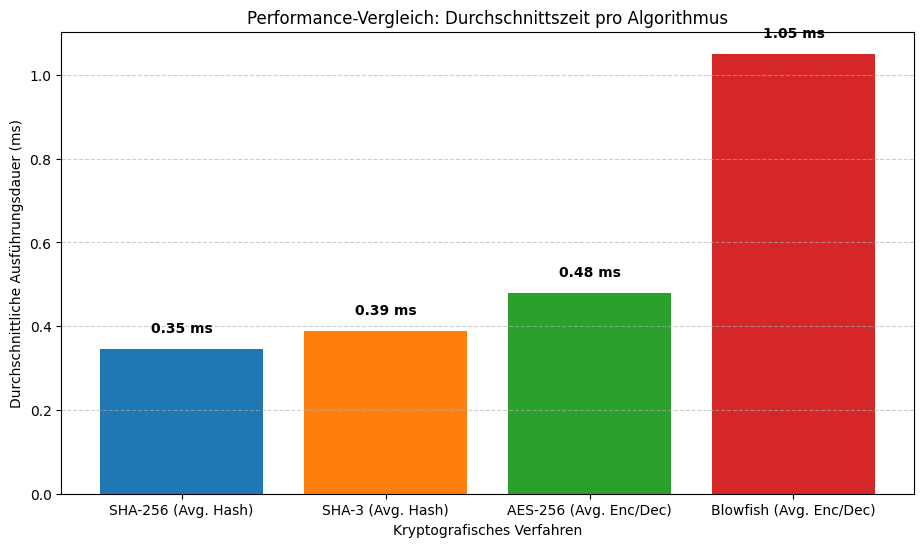

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Variablen-Deklaration (MÜSSEN MIT IHREN MESSWERTEN IM NOTEBOOK VORHANDEN SEIN) ---

# SHA-256 Zeiten (in Sekunden)
time_sha256_orig = first_execution_time
time_sha256_mod  = second_execution_time_mod

# SHA3-256 Zeiten (in Sekunden)
time_sha3_orig = third_execution_time
time_sha3_mod  = fourth_execution_time_mod

# AES-256 Zeiten (in Millisekunden)
time_aes_enc = aesencryption_time
time_aes_dec = aesdecryption_time

# Blowfish Zeiten (in Millisekunden)
time_blowfish_enc = encryption_time
time_blowfish_dec = decryption_time


# --- 2. Berechnung der Mittelwerte (in Millisekunden) ---

# 1. Hashing: Mittelwert aus Original und Geändert (logische Einheit ist der Algorithmus)
avg_time_sha256 = np.mean([time_sha256_orig, time_sha256_mod]) * 1000
avg_time_sha3 = np.mean([time_sha3_orig, time_sha3_mod]) * 1000

# 2. Verschlüsselung: Mittelwert aus Verschlüsselung und Entschlüsselung (logische Einheit ist der Prozess)
avg_time_aes = np.mean([time_aes_enc, time_aes_dec])
avg_time_blowfish = np.mean([time_blowfish_enc, time_blowfish_dec])


# --- 3. Daten für das Diagramm ---

verfahren = [
    'SHA-256 (Avg. Hash)',
    'SHA-3 (Avg. Hash)',
    'AES-256 (Avg. Enc/Dec)',
    'Blowfish (Avg. Enc/Dec)'
]
dauer = [
    avg_time_sha256,
    avg_time_sha3,
    avg_time_aes,
    avg_time_blowfish
]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']


# --- 4. Balkendiagramm erstellen ---
plt.figure(figsize=(11, 6))
bars = plt.bar(verfahren, dauer, color=colors)

# Beschriftung der Balken mit den gerundeten Mittelwerten
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + max(dauer)*0.03,
             f'{yval:.2f} ms', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel('Kryptografisches Verfahren')
plt.ylabel('Durchschnittliche Ausführungsdauer (ms)')
plt.title('Performance-Vergleich: Durchschnittszeit pro Algorithmus')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

## Interpretation

Die Interpretation umfasst hier eine aussagekräftige Tabelle, welche die Verfahren miteinander vergleicht, sodass Anwender und Leser auf einen Blick entscheiden können, worauf der Fokus liegt und welches Verfahren sie priorisieren.

https://csrc.nist.gov/projects/hash-functions

https://csrc.nist.gov/files/pubs/fips/180-2/final/docs/fips180-2.pdf, S. 9

https://nvlpubs.nist.gov/nistpubs/fips/nist.fips.202.pdf S. 23

https://xn--verschlsselt-jlb.it/krypto-algorithmus-aes-knackbar/

https://netlibsecurity.com/articles/aes-is-the-gold-standard-abandoning-blowfish-and-3des/


| Verfahren        | Typ                 | Sicherheit                                                                                   | Performance                                  | Einsatz                                                       | Standardisierung          | Schlüssel-/Hashlänge                 | Bekannte Schwächen                         |
|------------------|---------------------|---------------------------------------------------------------------------------------------|----------------------------------------------|---------------------------------------------------------------|---------------------------|---------------------------------------|--------------------------------------------|
| SHA-2 (SHA-256)  | Hashfunktion        | Sehr sicher, weit verbreitet; resistent gegen bekannte Angriffe, aber langfristig evtl. durch Quantencomputer gefährdet | Schnell, hardwareunterstützt in modernen CPUs | Integritätsprüfung, digitale Signaturen, TLS, Blockchain       | NIST-Standard seit 2001   | 256 Bit Hash                          | Keine praktischen; evtl. in Zukunft Quanten |
| SHA-3 (SHA3-256) | Hashfunktion        | Sehr sicher; moderner Standard, resistent gegen bekannte Angriffe; höhere Sicherheit gegenüber SHA-2 | Ähnlich wie SHA-2, aber effizient implementierbar | Integritätsprüfung, moderne Anwendungen, künftige Standards | NIST-Standard seit 2015   | 256 Bit Hash                          | Keine bekannten Schwächen                   |
| AES              | Symm. Verschlüsselung | Sehr sicher; aktueller Verschlüsselungsstandard (AES-128/192/256), stark gegen Brute-Force  | Sehr schnell, besonders mit Hardwarebeschleunigung | Symmetrische Verschlüsselung (Dateien, Festplatten, Netzwerke) | NIST-Standard seit 2001   | 128 / 192 / 256 Bit Schlüssel         | Keine bekannten, sicher bei richtiger Nutzung |
| Blowfish         | Symm. Verschlüsselung | Sicher, aber veraltet im Vergleich zu AES; Schlüsselgröße bis 448 Bit, keine großen Schwächen | Schnell in Software, aber schwächer optimiert als AES | Ältere Anwendungen, VPNs, teilweise noch in Legacy-Systemen | Nicht genormt, 1993 entwickelt | 32 bis 448 Bit Schlüssel              | 64-Bit Blockgröße → Problem bei großen Datenmengen |


# Hinweis zur Verwendung von generativer KI


Dieser Code wurde unter Verwendung eines KI-Modells (Google Gemini 2.5 Flash) zur Unterstützung entwickelt. Das KI-Modell wurde verwendet, um die Markdowns zu formatieren, Erklärungen bereitzustellen und Vorschläge für die Implementierung zu machen. Die endgültige Validierung, Anpassung und Verantwortung für die Korrektheit des Codes und der Erklärungen liegt bei der Autorin.
